In [ ]:
import sys
import os
from pathlib import Path

pwd  = Path(os.getcwd())
sys.path.append(str(pwd.parent.parent)) # needed to use "koray" module

In [1]:
import pandas as pd
import numpy as np

In [2]:
from koray.feature_calculation.util import get_features

conference_invitations = [
# 'NeurIPS.cc/2022/Conference/-/Blind_Submission',
'ICLR.cc/2023/Conference/-/Blind_Submission',
# 'ICLR.cc/2022/Conference/-/Blind_Submission',
# 'ICLR.cc/2021/Conference/-/Blind_Submission',
# 'ICLR.cc/2020/Conference/-/Blind_Submission',
]

# feature_df = list(get_features(conference_invitations, disable_cache=True))
feature_df = list(get_features(conference_invitations))
df = pd.concat(feature_df)
df

ModuleNotFoundError: No module named 'koray'

In [ ]:
df['reviewer_correctness_list_agg']

0                [3, 3, 2]
1          [4, 3, 3, 2, 3]
2             [4, 3, 4, 3]
3          [1, 3, 4, 2, 3]
4                [3, 4, 3]
               ...        
3791          [3, 4, 3, 4]
3792          [3, 4, 4, 3]
3793    [3, 3, 3, 2, 2, 3]
3794             [2, 4, 4]
3795          [2, 4, 4, 4]
Name: reviewer_correctness_list_agg, Length: 3796, dtype: object

In [ ]:
# columns that have numerical values
numerical_columns = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
numerical_columns

['abstract_length',
 'author_count',
 'citation_count',
 'conference_year',
 'keyword_count',
 'paper_topic_salience',
 'reviewer_confidence_coefficient_of_variation',
 'reviewer_confidence_mean_absolute_deviation',
 'reviewer_confidence_nanmax',
 'reviewer_confidence_nanmean',
 'reviewer_confidence_nanmedian',
 'reviewer_confidence_nanmin',
 'reviewer_confidence_nanstd',
 'reviewer_confidence_nanvar',
 'reviewer_confidence_num_unique_values',
 'reviewer_confidence_var_to_mean_ratio',
 'reviewer_confidence_yusuf_max_diff',
 'reviewer_correctness_coefficient_of_variation',
 'reviewer_correctness_mean_absolute_deviation',
 'reviewer_correctness_nanmax',
 'reviewer_correctness_nanmean',
 'reviewer_correctness_nanmedian',
 'reviewer_correctness_nanmin',
 'reviewer_correctness_nanstd',
 'reviewer_correctness_nanvar',
 'reviewer_correctness_num_unique_values',
 'reviewer_correctness_var_to_mean_ratio',
 'reviewer_correctness_yusuf_max_diff',
 'reviewer_empirical_novelty_and_significance_coef

/Users/koray/data-literacy-group16/koray/.venv/lib/python3.13/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/x5/q8ktycwd5zv7_kvsf2h0_gj00000gn/T/ipykernel_28679/983765862.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue='is_high_discrepancy', fill=True, common_norm=False, alpha=0.5)


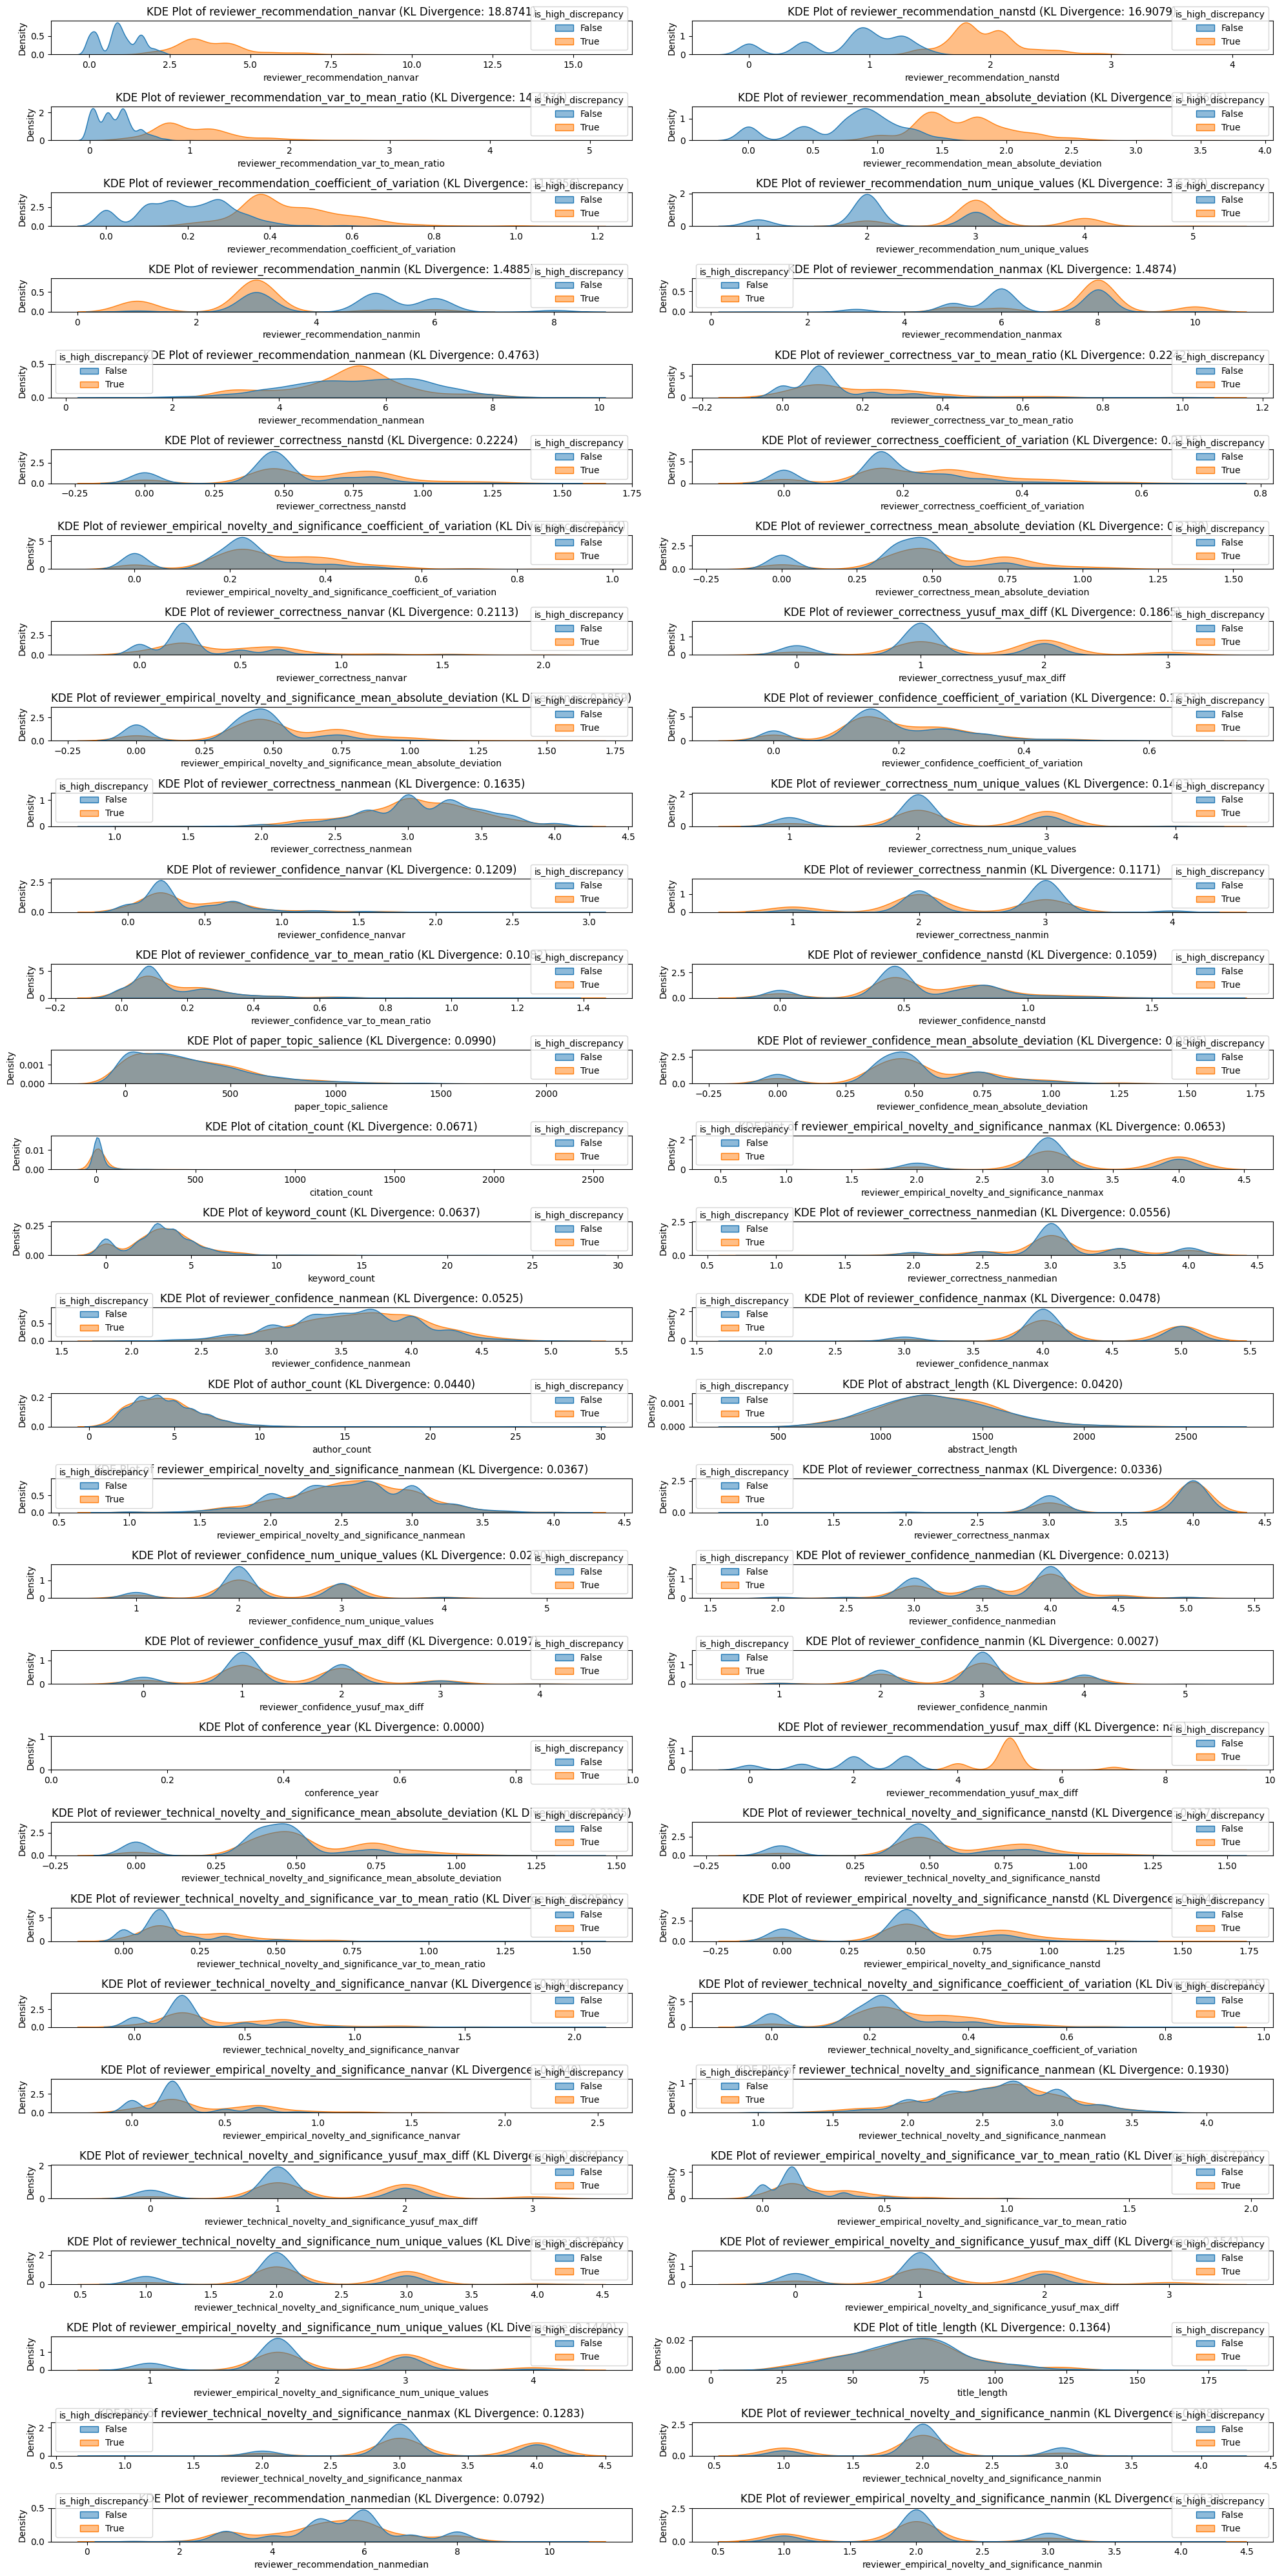

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Calculate KL divergence
def calculate_kl_divergence(df, column, group_col='is_high_discrepancy'):
    group_0 = df[df[group_col] == 0][column].dropna()
    group_1 = df[df[group_col] == 1][column].dropna()
    
    # Calculate histograms for each group
    p, bins = np.histogram(group_0, bins=30, density=True)
    q, _ = np.histogram(group_1, bins=bins, density=True)
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    # Normalize to ensure they are probabilities
    p = p / p.sum()
    q = q / q.sum()
    
    # Calculate KL divergence
    return entropy(p, q)

# Compute KL divergence for all numerical columns
kl_divergences = {
    col: calculate_kl_divergence(df, col, group_col='is_high_discrepancy')
    for col in numerical_columns
}

# Sort numerical columns by KL divergence in descending order
sorted_columns = sorted(kl_divergences, key=kl_divergences.get, reverse=True)
# sorted_columns = sorted_columns[:32]
sorted_columns = sorted_columns[:60] # matplotlib can't handle more than 62 subplots

plt.figure(figsize=(20, 40))
for i, col in enumerate(sorted_columns, 1):
    plt.subplot(len(sorted_columns) // 2, 2, i)
    sns.kdeplot(data=df, x=col, hue='is_high_discrepancy', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'KDE Plot of {col} (KL Divergence: {kl_divergences[col]:.4f})')

plt.tight_layout()
plt.show()


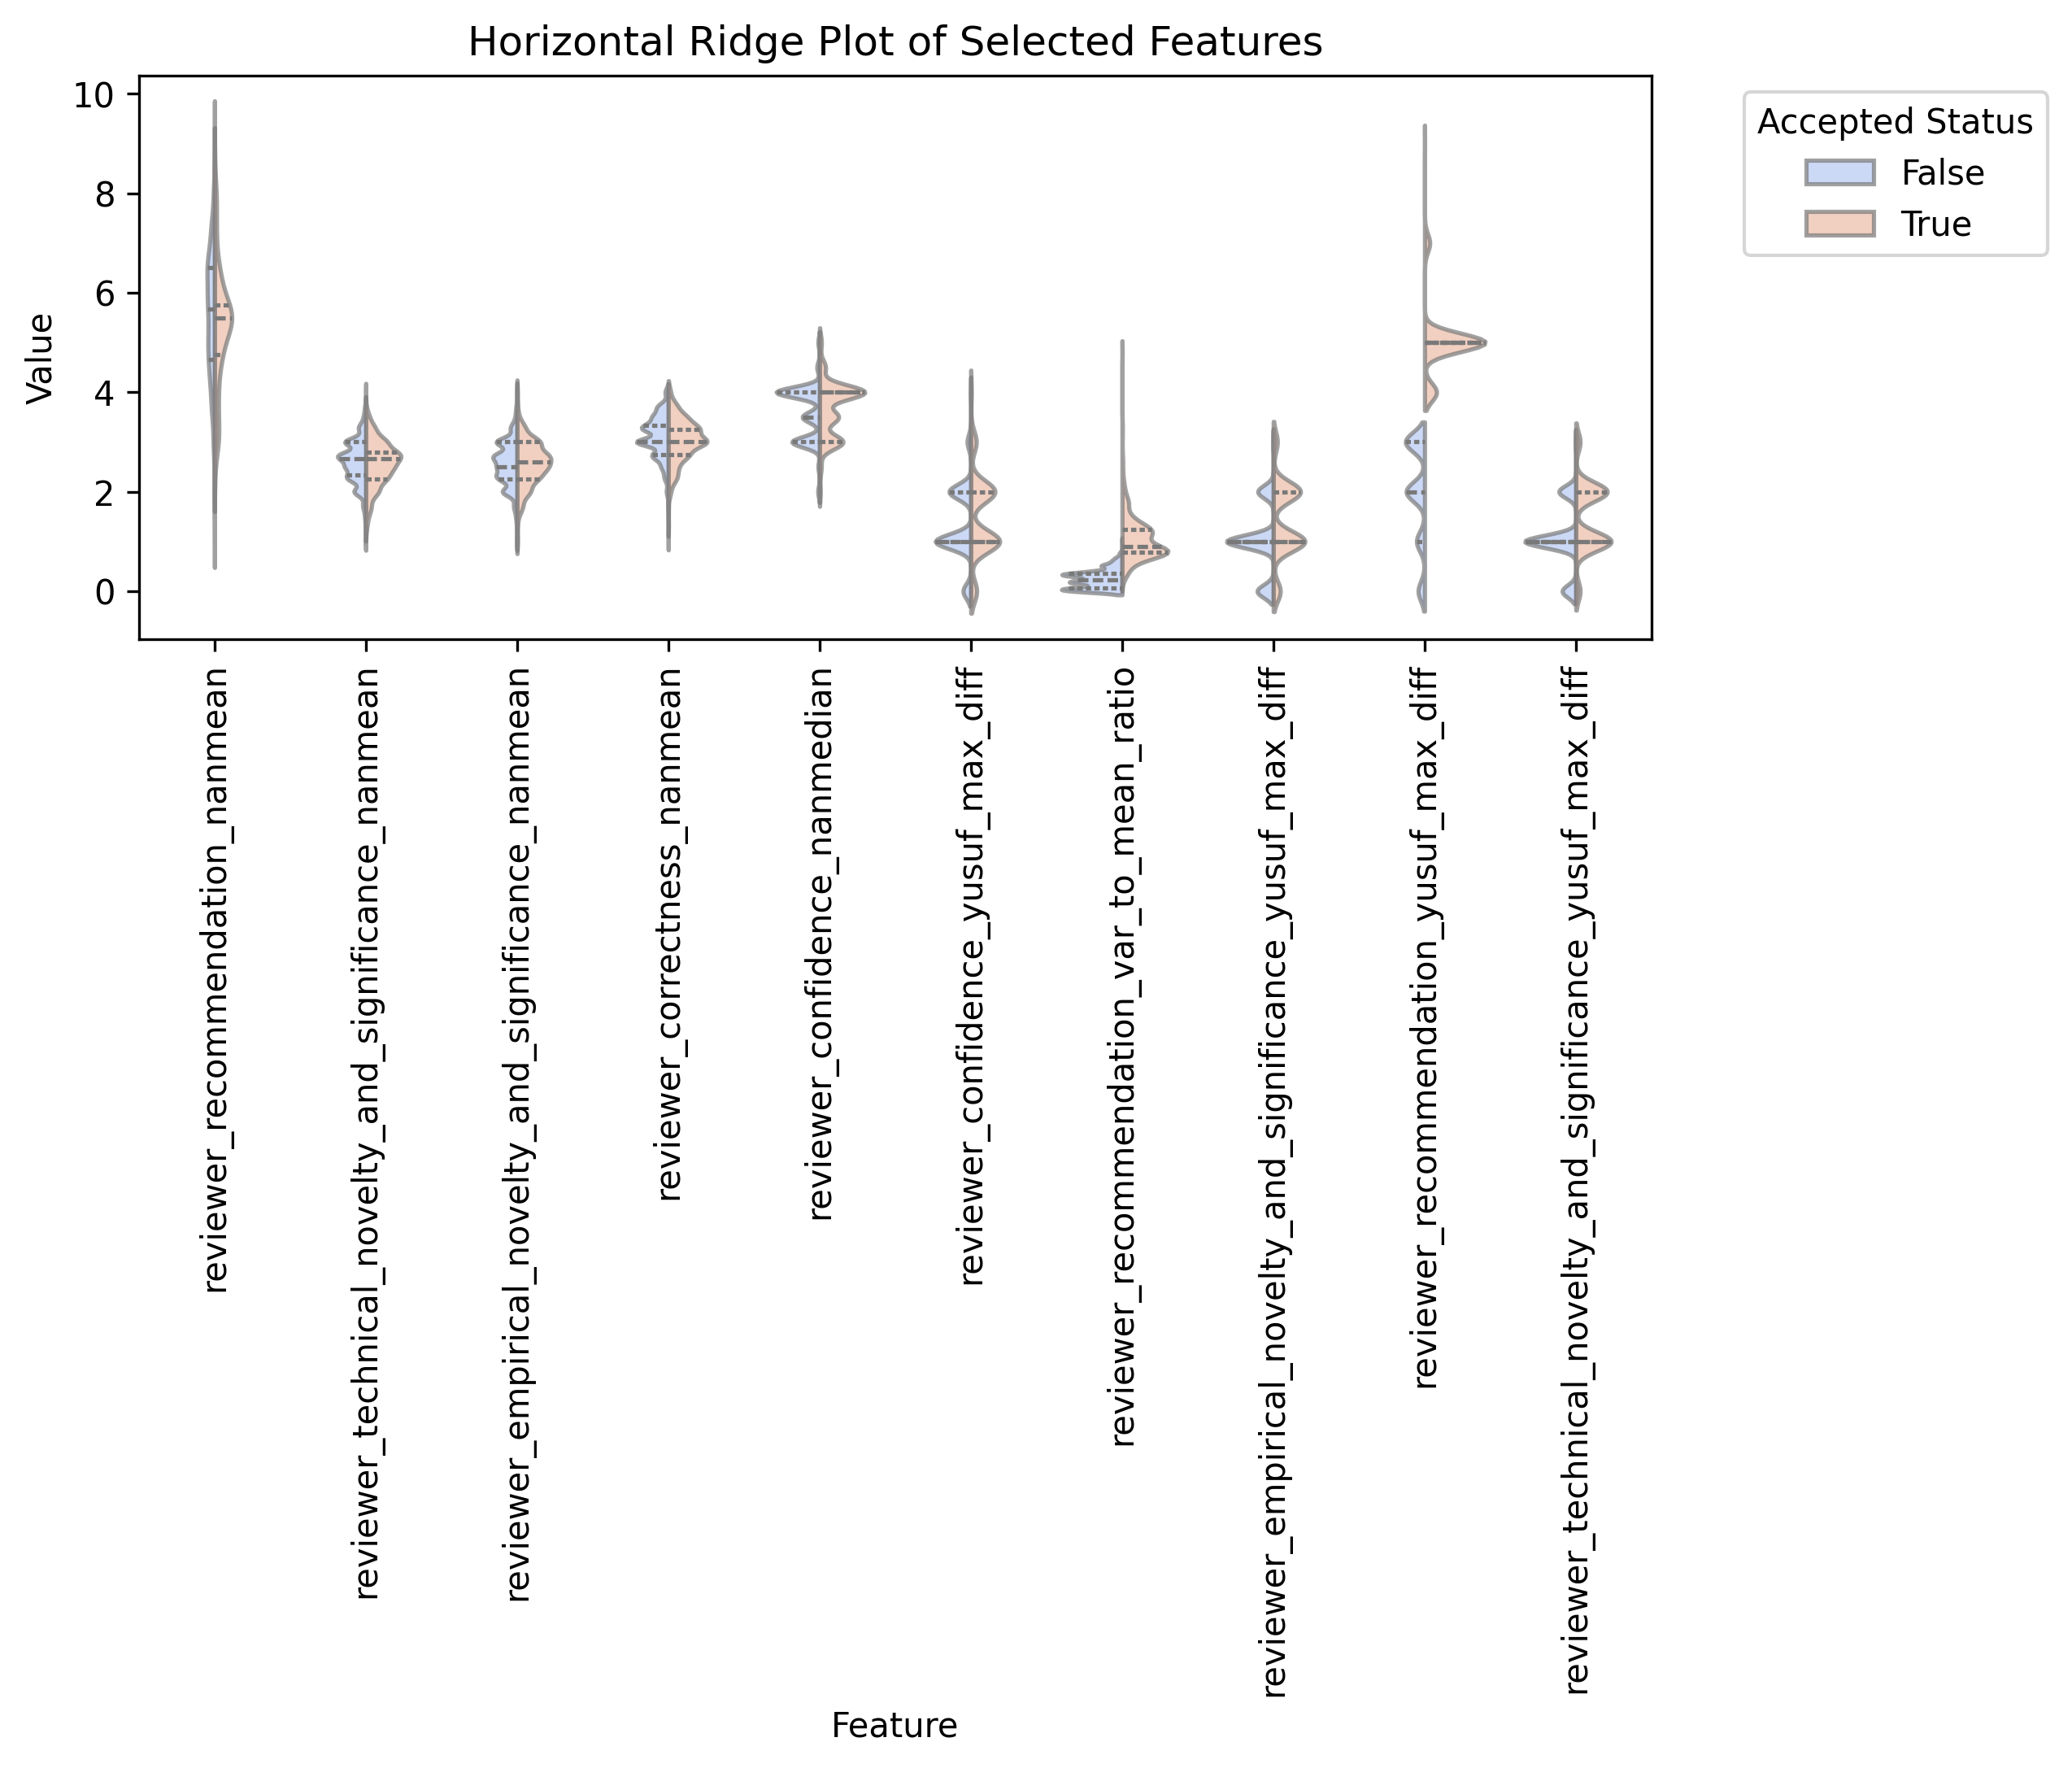

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top N columns based on KL divergence
# selected_columns = sorted_columns[:8]  # Adjust as needed
selected_columns = [
'reviewer_recommendation_nanmean',
'reviewer_technical_novelty_and_significance_nanmean',
'reviewer_empirical_novelty_and_significance_nanmean',
'reviewer_correctness_nanmean',
'reviewer_confidence_nanmedian',
'reviewer_confidence_yusuf_max_diff',
'reviewer_recommendation_var_to_mean_ratio',
'reviewer_empirical_novelty_and_significance_yusuf_max_diff',
'reviewer_recommendation_yusuf_max_diff',
'reviewer_technical_novelty_and_significance_yusuf_max_diff',
    ]


# Reshape data for seaborn
df_melted = df.melt(id_vars="is_high_discrepancy", value_vars=selected_columns, var_name="Feature", value_name="Value")

# Create a ridge plot with swapped axes
plt.figure(dpi=300, figsize=(8, 3))
sns.violinplot(
    data=df_melted,
    y="Value",  # Swap axes (was x)
    x="Feature",  # Swap axes (was y)
    hue="is_high_discrepancy",
    split=True,  # Shows both categories in the same violin
    inner="quartile",
    palette="coolwarm",
    alpha=0.7
)

plt.title("Horizontal Ridge Plot of Selected Features")
plt.ylabel("Value")
plt.xlabel("Feature")
plt.xticks(rotation=90)  # Rotate labels for better visibility
plt.legend(title="Accepted Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


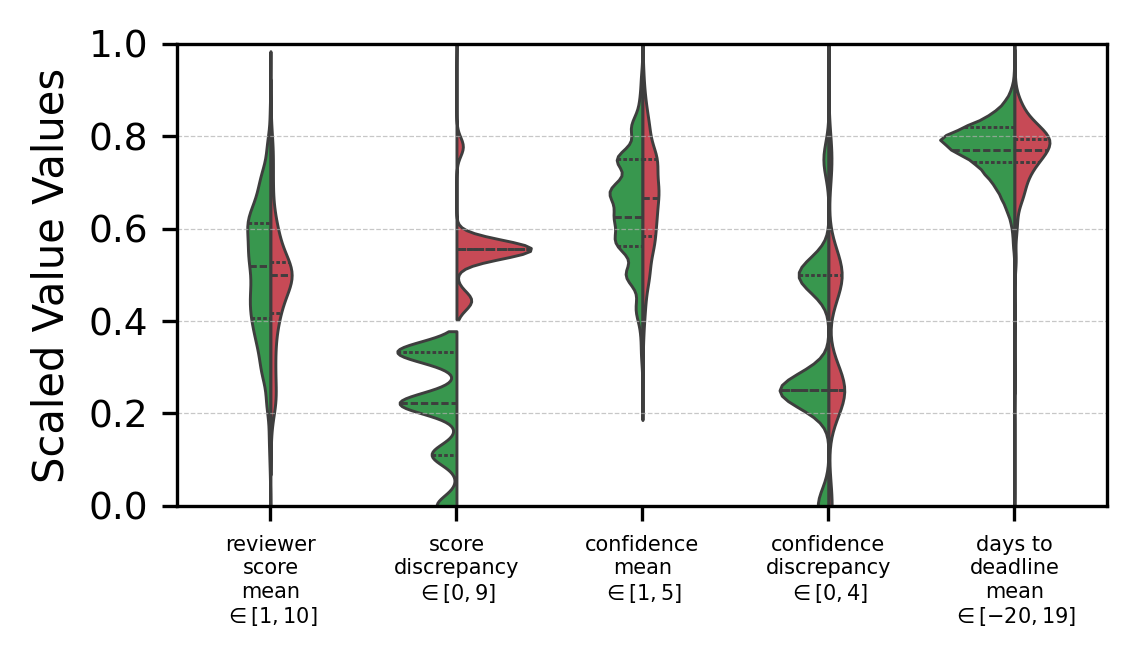

In [ ]:
from typing import Optional
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_ridge_kde(df: pd.DataFrame,
                   selected_columns: list,
                   hue_col: str = "is_high_discrepancy",
                   rename_map: Optional[dict] = None,
                   ):
    """
    Creates a ridge (violin) plot for the given selected columns, comparing distributions based on a categorical hue.
    """

    # Apply renaming if provided
    if rename_map:
        df = df.rename(columns=rename_map)
        selected_columns = [rename_map.get(col, col) for col in selected_columns]

    # Melt dataframe for seaborn
    df_melted = df.melt(id_vars=hue_col, value_vars=selected_columns, var_name="Feature", value_name="Value")

    # Create the figure
    plt.figure(dpi=300, figsize=(4, 2))

    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)

    # Ridge plot using violin plots with swapped axes (split violins)
    custom_palette = {
        False: '#28a745',
        True: '#dc3545', 
    }
    # sns.set_palette(custom_palette)
    sns.violinplot(
        data=df_melted,
        y="Value",  # Place features on the y-axis
        x="Feature",  # Place features on the x-axis
        hue=hue_col,
        split=True,  # Show both categories of hue ('True' vs. 'False')
        inner="quart",  # Show the quartiles within the violins
        # palette="coolwarm",  # Color palette
        palette=custom_palette,
        alpha=1,  # Less transparency for a more vibrant plot
        linewidth=0.7,  # Thicker contour lines for more emphasis

    )
    plt.ylim(0, 1)

    # middle_index = len(selected_columns) / 2 - 0.5  # Find the middle position
    # plt.axvline(x=middle_index, color='red', linestyle='--', linewidth=0.8, alpha=0.7)  # Add vertical line

    # Formatting
    plt.xticks(rotation=0, fontsize=5)  # Set smaller font size for x-axis labels

    # plt.yticks(np.arange(0, 11, 1), fontsize=7)  # Set smaller font size for y-axis labels
    plt.yticks(np.arange(0, 1.0001, 0.2), fontsize=9)  # Set smaller font size for y-axis labels
    plt.xlabel("", fontsize=10)  # Set smaller font size for x-axis label
    plt.ylabel("Scaled Value Values", fontsize=10)  # Set smaller font size for y-axis label
    # plt.title("Ridge Plot of Selected Features (Split by 'is_high_discrepancy')", fontsize=14)  # Set smaller font size for title

    plt.legend().remove()

    # save as pdf
    plt.savefig('ridge_plot.pdf', format='pdf', bbox_inches='tight')

    plt.show()


def rescale_columns(df: pd.DataFrame, columns, maxmin_cols):
    """
    Rescale each column in `columns` to lie between 0 and 1 using min-max scaling.
    Any values outside the [0, 1] range will be clipped.
    """
    for col in columns:

        min_val = maxmin_cols[col][0]
        max_val = maxmin_cols[col][1]
        # print(f"{col}: {min_val} - {max_val}")

        if col == 'citation_count':
            df[col] = np.log1p(df[col])  # log(1 + x) prevents log(0) issues
            min_val, max_val = np.log1p(np.array([min_val, max_val]))  # Adjust min-max after log


        # Avoid division by zero if the column has constant values
        if max_val != min_val:
            df[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df[col] = 0  # If the column is constant, set all values to 0 (or 1, depending on your preference)

        # Clip values to ensure they lie between 0 and 1
        df[col] = df[col].clip(0, 1)

        # print(f"{col}: {df[col].min()} - {df[col].max()}")

        # if 'citation_count' in col:
        #     # take the log of citation count
        #     df[col] = np.log(df[col] + 1)

    return df


# rename_map = {col: f"F{i+1}" for i, col in enumerate(selected_columns)}
rename_map = {
    'reviewer_recommendation_nanmean':  'reviewer\nscore\nmean\n$\\in [1,10]$',
    'reviewer_recommendation_yusuf_max_diff':  'score\ndiscrepancy\n$\\in [0,9]$',
    'reviewer_confidence_nanmean': 'confidence\nmean\n$\\in [1,5]$',
    'reviewer_confidence_yusuf_max_diff': 'confidence\ndiscrepancy\n$\\in [0,4]$',
    # 'time_to_deadline_mean_seconds': 'seconds\ntimedelta\nmean\n$\\in [-1e6, 2e6]$',
    'time_to_deadline_mean_days': 'days to\ndeadline\nmean\n$\\in [-20, 19]$',
    # 'paper_topic_salience': 'paper\ntopic\nsalience\n$\\in [0, 1000]$',
    'citation_count': 'log\npaper\ncitation\ncount\n$\\in [0, 2500]$',
}


# Select columns for ridge plot

selected_columns = [k for k in rename_map.keys()]
sorted_columns = sorted(selected_columns, key=lambda col: kl_divergences[col], reverse=True)


maxmin_cols = {k: eval(v.split("\\in ")[-1][:-1]) for k, v in rename_map.items()}


df2 = rescale_columns(df.copy(deep=True), selected_columns, maxmin_cols)


plot_ridge_kde(df2, selected_columns, rename_map=rename_map)

In [ ]:
df['time_to_deadline_mean_days'].describe()

count    3796.000000
mean        9.942571
std         2.807081
min       -62.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        19.000000
Name: time_to_deadline_mean_days, dtype: float64

In [ ]:
df['paper_topic_salience'].describe()

count    3796.000000
mean      311.221022
std       282.800188
min         0.000000
25%        98.000000
50%       252.000000
75%       458.250000
max      2111.000000
Name: paper_topic_salience, dtype: float64

In [ ]:
df['citation_count']

0         0.0
1        18.0
2        53.0
3         0.0
4         3.0
        ...  
3791      2.0
3792    200.0
3793      1.0
3794      5.0
3795      4.0
Name: citation_count, Length: 3796, dtype: float64

In [ ]:
kl_divergences

{'abstract_length': 0.04199637872678653,
 'author_count': 0.0440356806942171,
 'citation_count': 0.06712517800551145,
 'conference_year': 1.1713006720721583e-26,
 'keyword_count': 0.06374863563797882,
 'paper_topic_salience': 0.09904065886956763,
 'reviewer_confidence_coefficient_of_variation': 0.16526474662896215,
 'reviewer_confidence_mean_absolute_deviation': 0.08948525797747284,
 'reviewer_confidence_nanmax': 0.047795731406123976,
 'reviewer_confidence_nanmean': 0.05245960457392473,
 'reviewer_confidence_nanmedian': 0.021306830034111737,
 'reviewer_confidence_nanmin': 0.002650715447967329,
 'reviewer_confidence_nanstd': 0.10587603309775487,
 'reviewer_confidence_nanvar': 0.12089984361689113,
 'reviewer_confidence_num_unique_values': 0.028959554855694486,
 'reviewer_confidence_var_to_mean_ratio': 0.108206161527199,
 'reviewer_confidence_yusuf_max_diff': 0.01970718558737653,
 'reviewer_correctness_coefficient_of_variation': 0.2155477885598433,
 'reviewer_correctness_mean_absolute_dev